In [1]:
import depthai as dai
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
calib = dai.CalibrationHandler("dataset/calib.json")

originalRes = (1920, 1200)
res = (1280, 1080)
w, h = res

centerCropOffset = ((originalRes[0] - res[0]) / 2, (originalRes[1] - res[1]) / 2)

offsetWidth, offsetHeight = centerCropOffset

topLeftPixel = dai.Point2f(0, offsetHeight)
bottomRightPixel = dai.Point2f(res[0], res[1] + offsetHeight)

K_l = np.array(calib.getCameraIntrinsics(calib.getStereoLeftCameraId(), originalRes[0], originalRes[1], dai.Point2f(0,offsetHeight), dai.Point2f(w,h+offsetHeight), False))
K_r = np.array(calib.getCameraIntrinsics(calib.getStereoRightCameraId(), originalRes[0], originalRes[1], dai.Point2f(0,offsetHeight), dai.Point2f(w,h+offsetHeight), False))

D_l = np.array(calib.getDistortionCoefficients(calib.getStereoLeftCameraId())[:4])
D_r = np.array(calib.getDistortionCoefficients(calib.getStereoRightCameraId())[:4])

tranformation = np.array(calib.getCameraExtrinsics(calib.getStereoLeftCameraId(), calib.getStereoRightCameraId()))
R = tranformation[:3, :3]
T = tranformation[:3, 3]


Lets create a reference image to visualize the (un)distortion

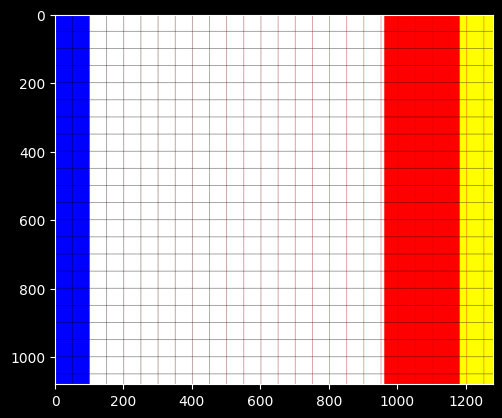

In [14]:
w, h = res

img = np.ones((h, w, 3), np.uint8)*255
img[:, :100, :] = np.array([0,0,255])
img[:, originalRes[0]//2:, :] = np.array([255,0,0])
img[:, -100:, :] = np.array([255,255,0])
for i in range(0, h, 50):
	cv2.line(img, (0, i), (w, i), (0, 0, 0))
for i in range(0, w, 50):
	cv2.line(img, (i, 0), (i, h), ((i/w*255), 0, 0))


plt.imshow(img)

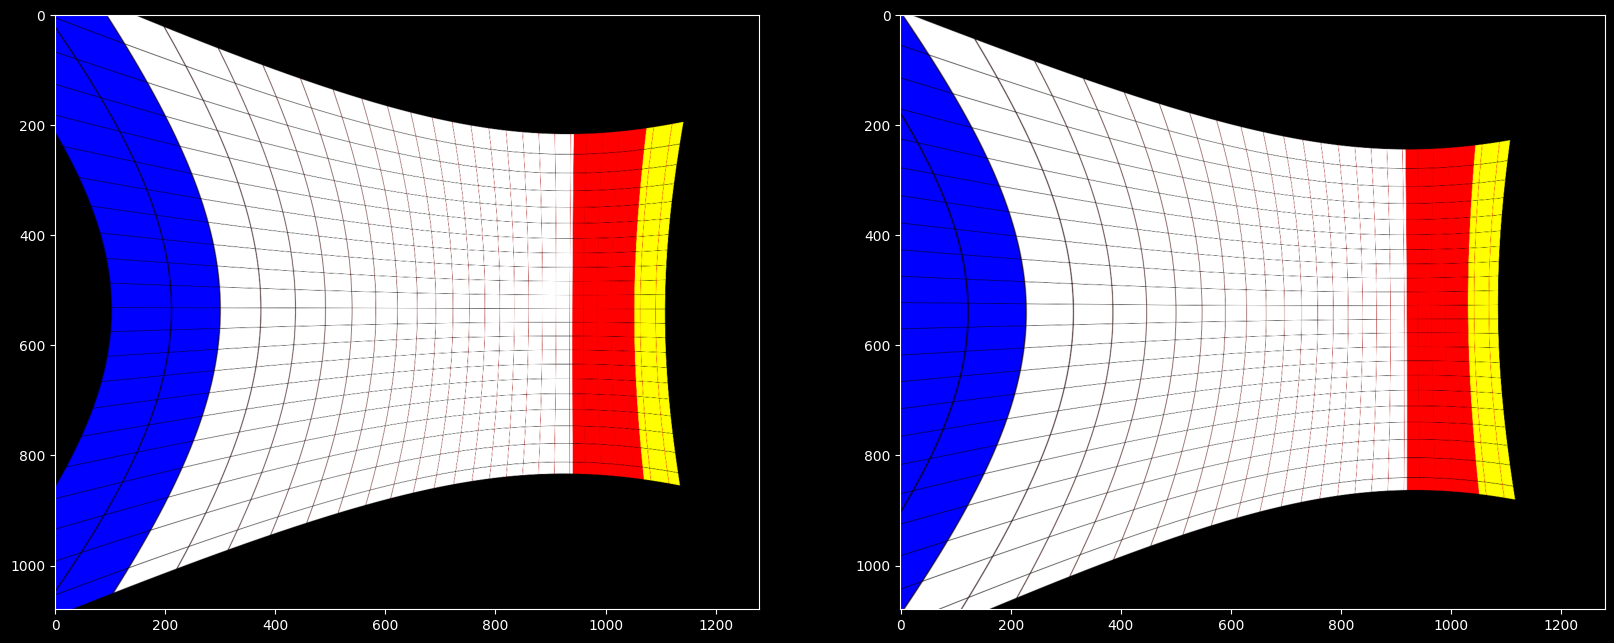

In [18]:
R_l, R_r, P_l, P_r, Q = cv2.fisheye.stereoRectify(K_l, D_l, K_r, D_r, res, R, T, flags=cv2.CALIB_ZERO_DISPARITY, balance=1)

rectify_map_l = cv2.fisheye.initUndistortRectifyMap(K=K_l, D=D_l, R=R_l, P=P_l, size=res, m1type=cv2.CV_32F)
rectify_map_r = cv2.fisheye.initUndistortRectifyMap(K=K_r, D=D_r, R=R_r, P=P_r, size=res, m1type=cv2.CV_32F)
img_rectified_l = cv2.remap(img, rectify_map_l[0], rectify_map_l[1], cv2.INTER_LINEAR)
img_rectified_r = cv2.remap(img, rectify_map_r[0], rectify_map_r[1], cv2.INTER_LINEAR)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(img_rectified_l)
plt.subplot(1, 2, 2)
plt.imshow(img_rectified_r)

Lets shift the whole image to remove the black border

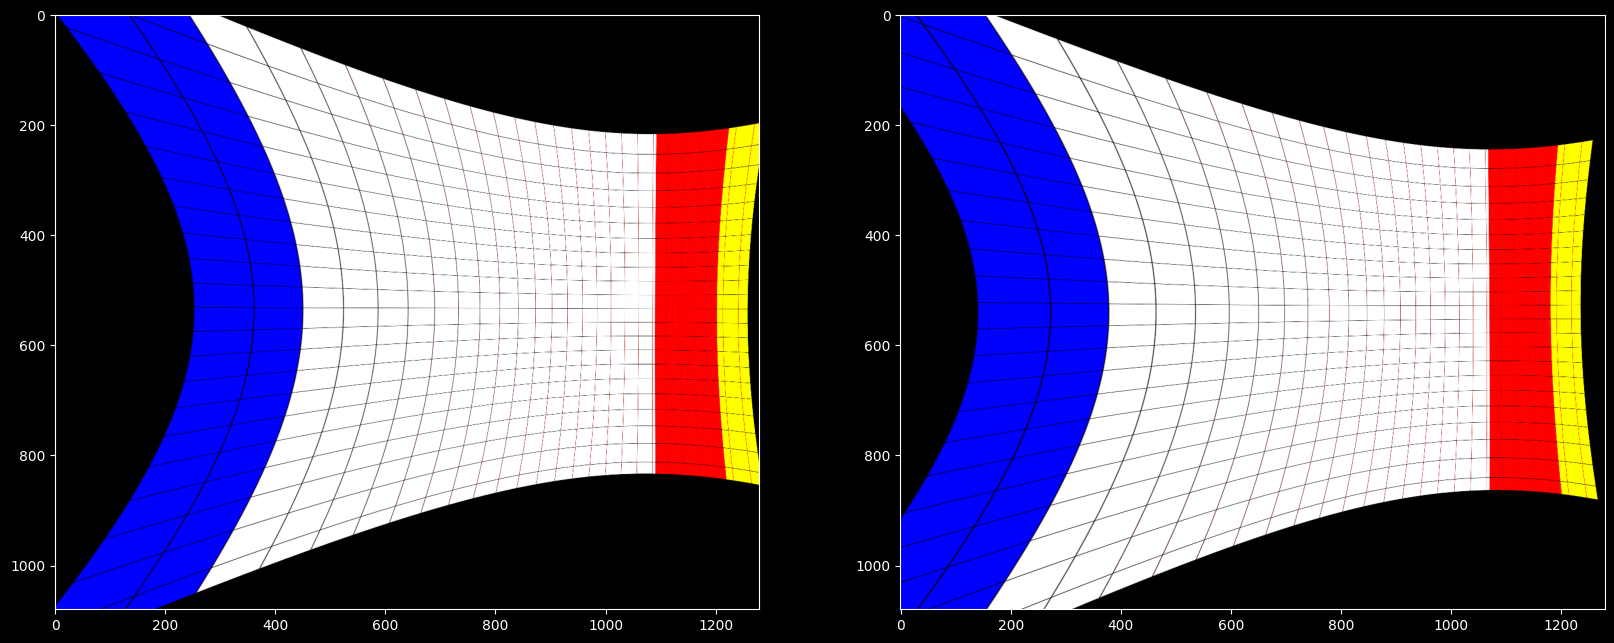

In [21]:
R_l, R_r, P_l, P_r, Q = cv2.fisheye.stereoRectify(K_l, D_l, K_r, D_r, res, R, T, flags=cv2.CALIB_ZERO_DISPARITY, balance=1)
P_l[:,2] += np.array([150,0,0])
P_r[:,2] += np.array([150,0,0])
rectify_map_l = cv2.fisheye.initUndistortRectifyMap(K=K_l, D=D_l, R=R_l, P=P_l, size=res, m1type=cv2.CV_32F)
rectify_map_r = cv2.fisheye.initUndistortRectifyMap(K=K_r, D=D_r, R=R_r, P=P_r, size=res, m1type=cv2.CV_32F)
img_rectified_l = cv2.remap(img, rectify_map_l[0], rectify_map_l[1], cv2.INTER_LINEAR)
img_rectified_r = cv2.remap(img, rectify_map_r[0], rectify_map_r[1], cv2.INTER_LINEAR)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(img_rectified_l)
plt.subplot(1, 2, 2)
plt.imshow(img_rectified_r)

### Unsuccessful attempts

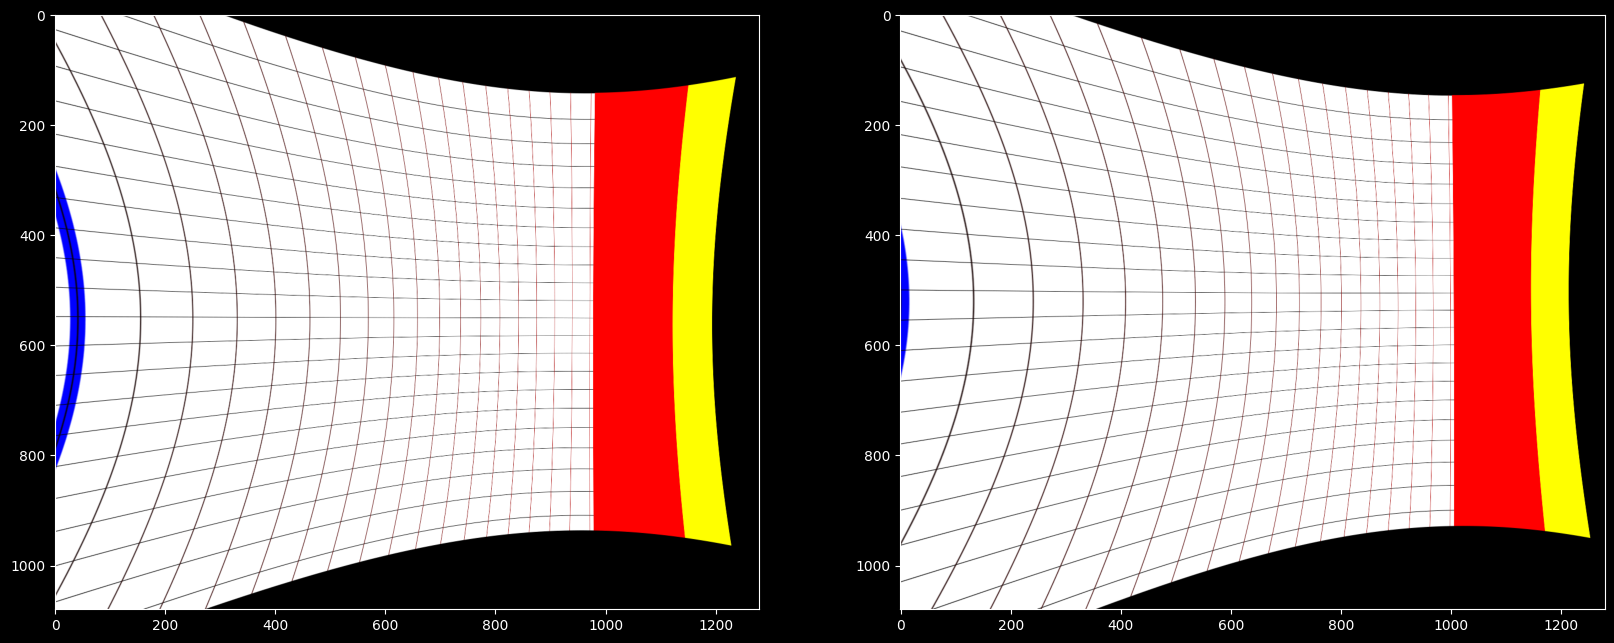

In [5]:
R_l, R_r, P_l, P_r, Q = cv2.fisheye.stereoRectify(K_l, D_l, K_r, D_r, res, R, T, flags=cv2.CALIB_ZERO_DISPARITY)

P_opt_l = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K_l, D_l, res, R_l, P_l, balance=0, fov_scale=1.3)
P_opt_r = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K_r, D_r, res, R_r, P_r, balance=0, fov_scale=1.3)

rectify_map_l = cv2.fisheye.initUndistortRectifyMap(K=K_l, D=D_l, R=R_l, P=P_opt_l, size=res, m1type=cv2.CV_32F)
rectify_map_r = cv2.fisheye.initUndistortRectifyMap(K=K_r, D=D_r, R=R_r, P=P_opt_r, size=res, m1type=cv2.CV_32F)
img_rectified_l = cv2.remap(img, rectify_map_l[0], rectify_map_l[1], cv2.INTER_LINEAR)
img_rectified_r = cv2.remap(img, rectify_map_r[0], rectify_map_r[1], cv2.INTER_LINEAR)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(img_rectified_l)
plt.subplot(1, 2, 2)
plt.imshow(img_rectified_r)

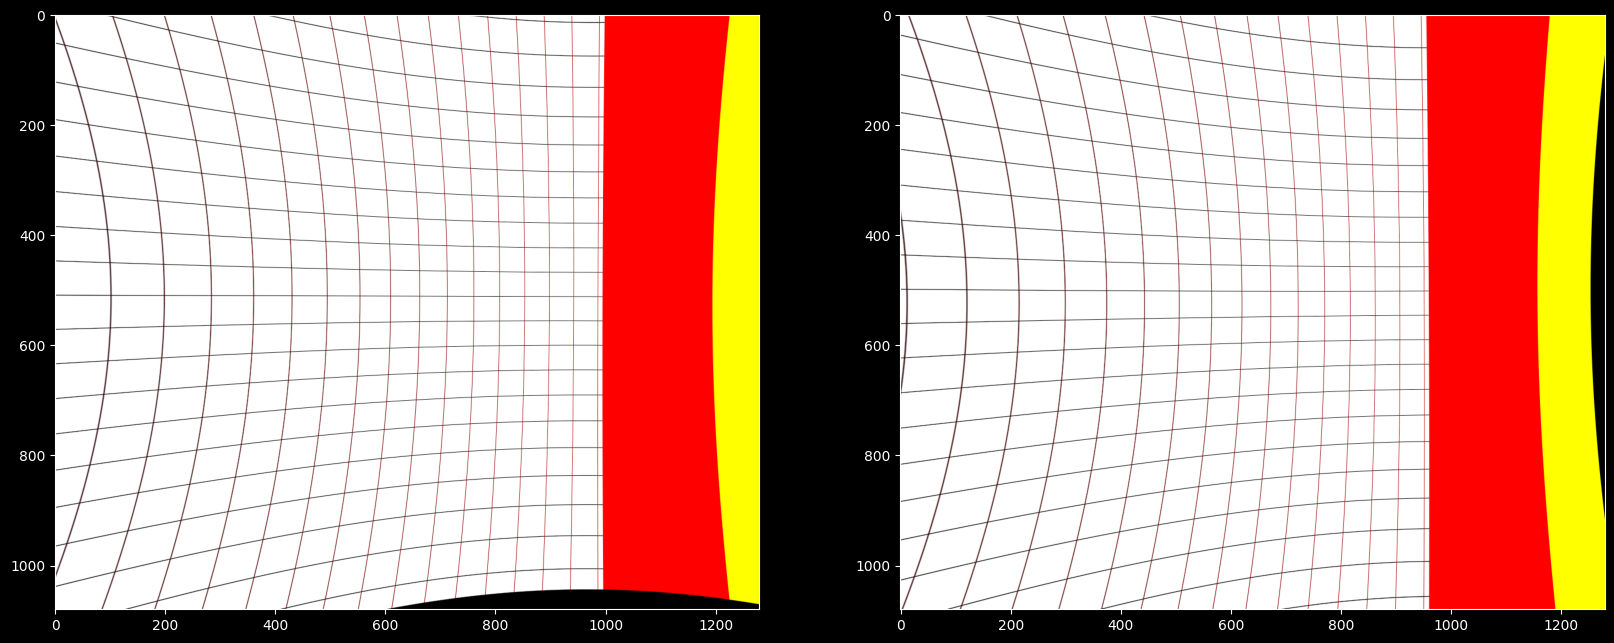

In [6]:
R_l, R_r, P_l, P_r, Q, _, _ = cv2.stereoRectify(K_l, D_l, K_r, D_r, res, R, T, flags=cv2.CALIB_ZERO_DISPARITY, newImageSize=res, alpha=2)

rectify_map_l = cv2.fisheye.initUndistortRectifyMap(K=K_l, D=D_l, R=R_l, P=P_l, size=res, m1type=cv2.CV_32F)
rectify_map_r = cv2.fisheye.initUndistortRectifyMap(K=K_r, D=D_r, R=R_r, P=P_r, size=res, m1type=cv2.CV_32F)
img_rectified_l = cv2.remap(img, rectify_map_l[0], rectify_map_l[1], cv2.INTER_LINEAR)
img_rectified_r = cv2.remap(img, rectify_map_r[0], rectify_map_r[1], cv2.INTER_LINEAR)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(img_rectified_l)
plt.subplot(1, 2, 2)
plt.imshow(img_rectified_r)

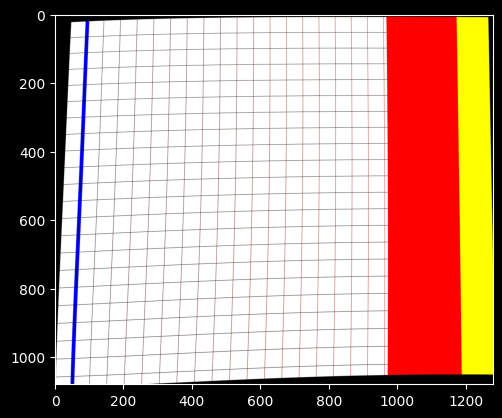

In [8]:
R_l, R_r, P_l, P_r, Q, _, _ = cv2.stereoRectify(K_l, D_l, K_r, D_r, res, R, T, flags=0, newImageSize=res, alpha=0.9)

opt_cam_matrix_l, roi_l = cv2.getOptimalNewCameraMatrix(K_l, D_l, res, 1)
opt_cam_matrix_r, roi_r = cv2.getOptimalNewCameraMatrix(K_r, D_r, res, 1)
rectify_map_l = cv2.initUndistortRectifyMap(K_l, D_l, R_l, opt_cam_matrix_l, res, cv2.CV_32F)
rectify_map_r = cv2.initUndistortRectifyMap(K_r, D_r, R_r, opt_cam_matrix_r, res, cv2.CV_32F)

img_rectified = cv2.remap(img, rectify_map_r[0], rectify_map_r[1], cv2.INTER_LINEAR)

plt.imshow(img_rectified)